In [1]:
!git clone https://github.com/raoyongming/DynamicViT.git

Cloning into 'DynamicViT'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 110 (delta 49), reused 90 (delta 32), pack-reused 0
Receiving objects: 100% (110/110), 4.42 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [2]:
!pip install timm

     |████████████████████████████████| 376 kB 5.5 MB/s 


In [3]:
import os
os.chdir("/content/DynamicViT")
os.mkdir("./pretrained")

In [4]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I" -O dynamic-vit_lv-m_r0.7.pth && rm -rf /tmp/cookies.txt
!mv ./dynamic-vit_lv-m_r0.7.pth ./pretrained/

--2021-12-21 17:27:53--  https://docs.google.com/uc?export=download&confirm=ujfD&id=1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I
Resolving docs.google.com (docs.google.com)... 108.177.111.100, 108.177.111.139, 108.177.111.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.111.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-84-docs.googleusercontent.com/docs/securesc/45l7luv8n7jq6aab4r3jrn253lkbqpuh/bq8gqg0gqv1hv3qmsrb6t0p3mifi7fgo/1640107650000/16817155093637665231/17349342189793529888Z/1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I?e=download [following]
--2021-12-21 17:27:53--  https://doc-14-84-docs.googleusercontent.com/docs/securesc/45l7luv8n7jq6aab4r3jrn253lkbqpuh/bq8gqg0gqv1hv3qmsrb6t0p3mifi7fgo/1640107650000/16817155093637665231/17349342189793529888Z/1dNab1B5ZOTVNpnpO6H1TsXKFM8BAlA3I?e=download
Resolving doc-14-84-docs.googleusercontent.com (doc-14-84-docs.googleusercontent.com)... 173.194.198.132, 2607:f8b0:4001:c1c::84
Conne

In [5]:
import torch
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from lvvit import LVViTDiffPruning

In [6]:
# build transforms
from torchvision import datasets, transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

t_resize_crop = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
])

t_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [7]:
# build model
BASE_RATE = 0.7
KEEP_RATE = [BASE_RATE, BASE_RATE ** 2, BASE_RATE ** 3]
PRUNING_LOC = [5, 10, 15]
CKPT_PATH = 'pretrained/dynamic-vit_lv-m_r0.7.pth'

model = LVViTDiffPruning(
    patch_size=16, embed_dim=512, depth=20, num_heads=8, mlp_ratio=3.,
    p_emb='4_2',skip_lam=2., return_dense=True, mix_token=True,
    pruning_loc=PRUNING_LOC, token_ratio=KEEP_RATE, viz_mode=True,
)

checkpoint = torch.load(CKPT_PATH, map_location='cpu')['model']
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
def get_keep_indices(decisions):
    keep_indices = []
    for i in range(3):
        if i == 0:
            keep_indices.append(decisions[i])
        else:
            keep_indices.append(keep_indices[-1][decisions[i]])
    return keep_indices
def gen_masked_tokens(tokens, indices, alpha=0.2):
    indices = [i for i in range(196) if i not in indices]
    tokens = tokens.copy()
    tokens[indices] = alpha * tokens[indices] + (1 - alpha) * 255
    return tokens

def recover_image(tokens):
    # image: (C, 196, 16, 16)
    image = tokens.reshape(14, 14, 16, 16, 3).swapaxes(1, 2).reshape(224, 224, 3)
    return image

def gen_visualization(image, decisions):
    keep_indices = get_keep_indices(decisions)
    image = np.asarray(image)
    image_tokens = image.reshape(14, 16, 14, 16, 3).swapaxes(1, 2).reshape(196, 16, 16, 3)

    stages = [
        recover_image(gen_masked_tokens(image_tokens, keep_indices[i]))
        for i in range(3)
    ]
    viz = np.concatenate([image] + stages, axis=1)
    return viz

(-0.5, 895.5, 223.5, -0.5)

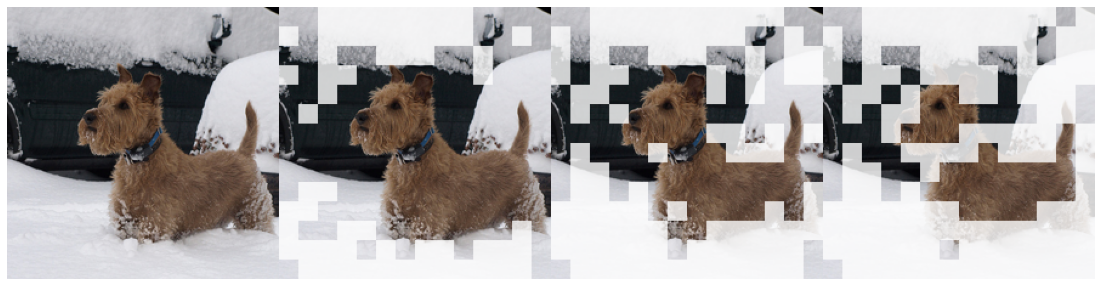

In [9]:
# visualization
# use a random image from IMAGE_ROOT

IMAGE_ROOT = 'imgs'
image_paths = glob.glob(f'imgs/*.jpg')
idx = np.random.randint(len(image_paths))
image_path = image_paths[idx]
image = Image.open(image_path)

image = t_resize_crop(image)
im_tensor = t_to_tensor(image).unsqueeze(0)

device = 'cpu'
model.to(device)
model.eval()
im_tensor = im_tensor.to(device)
with torch.cuda.amp.autocast():
    output, decisions = model(im_tensor)
decisions = [decisions[i][0][0].cpu().numpy() for i in range(3)]
viz = gen_visualization(image, decisions)

plt.figure(figsize=(20, 5))
plt.imshow(viz)
plt.axis('off')